# Datasource
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10694051/

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("attention_detection_dataset_v1.csv")
df.head()

,no_of_face,face_x,face_y,face_w,face_h,face_con,no_of_hand,pose,pose_x,pose_y,phone,phone_x,phone_y,phone_w,phone_h,phone_con,label
0,1,256.643658,144.163663,169.071331,169.066601,88.813317,0,down,-11.569698,-1.612015,0,0,0,0,0,0.00000,1
1,1,252.967014,137.871659,163.131542,163.126974,86.704057,0,down,-15.000000,10.000000,0,0,0,0,0,0.00000,1
2,1,254.416771,134.427950,155.147362,155.145836,88.408792,0,down,-12.705953,0.082978,0,0,0,0,0,0.00000,1
3,2,256.315517,246.199763,141.227055,141.227217,89.279491,2,right,32.585681,36.572800,1,117,137,276,421,0.86614,1
4,1,293.000126,285.859563,197.011509,196.998653,80.872309,2,forward,-4.013085,-9.905692,0,0,0,0,0,0.00000,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   no_of_face  4000 non-null   int64  
 1   face_x      4000 non-null   float64
 2   face_y      4000 non-null   float64
 3   face_w      4000 non-null   float64
 4   face_h      4000 non-null   float64
 5   face_con    4000 non-null   float64
 6   no_of_hand  4000 non-null   int64  
 7   pose        4000 non-null   object 
 8   pose_x      4000 non-null   float64
 9   pose_y      4000 non-null   float64
 10  phone       4000 non-null   int64  
 11  phone_x     4000 non-null   int64  
 12  phone_y     4000 non-null   int64  
 13  phone_w     4000 non-null   int64  
 14  phone_h     4000 non-null   int64  
 15  phone_con   4000 non-null   float64
 16  label       4000 non-null   int64  
dtypes: float64(8), int64(8), object(1)
memory usage: 531.4+ KB


# EDA

In [3]:
df['label'].value_counts()

label
0    2314
1    1686
Name: count, dtype: int64

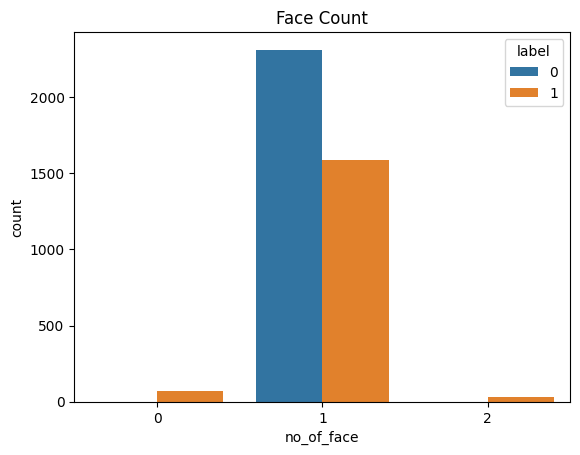

In [4]:
sns.countplot(data=df, x="no_of_face", hue='label')
plt.title("Face Count")
plt.show()

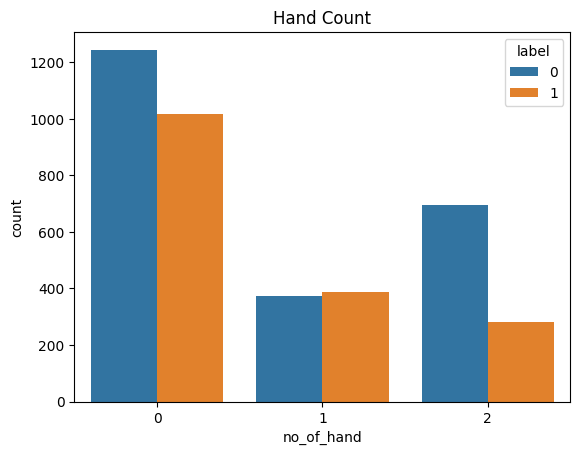

In [85]:
sns.countplot(data=df, x="no_of_hand", hue='label')
plt.title("Hand Count")
plt.show()

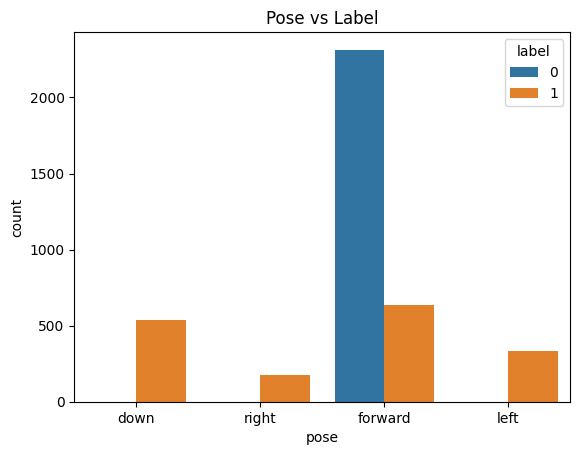

In [86]:
sns.countplot(data=df, x='pose', hue='label')
plt.title("Pose vs Label")
plt.show()

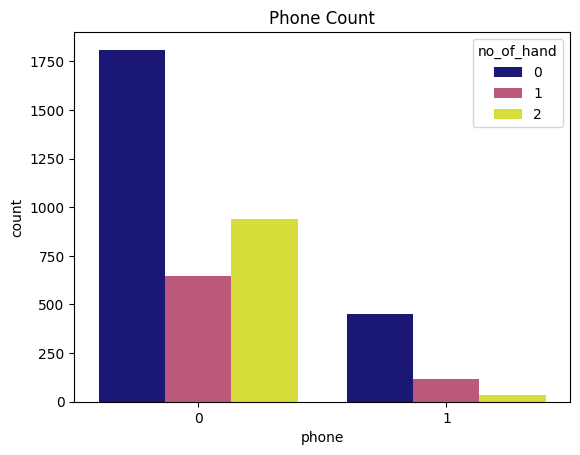

In [87]:
sns.countplot(data=df, x="phone", hue='no_of_hand', palette='plasma')
plt.title("Phone Count")
plt.show()

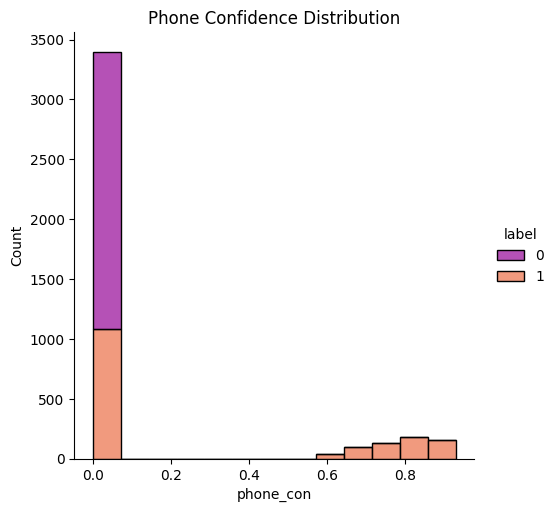

In [88]:
sns.displot(data=df, x='phone_con', hue='label', palette="plasma", multiple="stack")
plt.title("Phone Confidence Distribution")
plt.show()

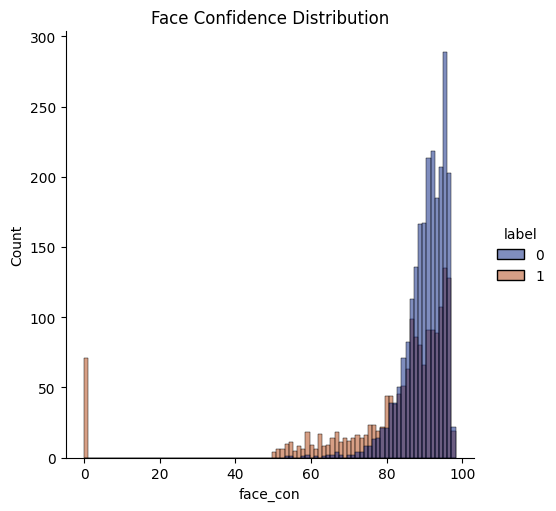

In [89]:
sns.displot(data=df, x='face_con', hue='label', palette='dark')
plt.title("Face Confidence Distribution")
plt.show()

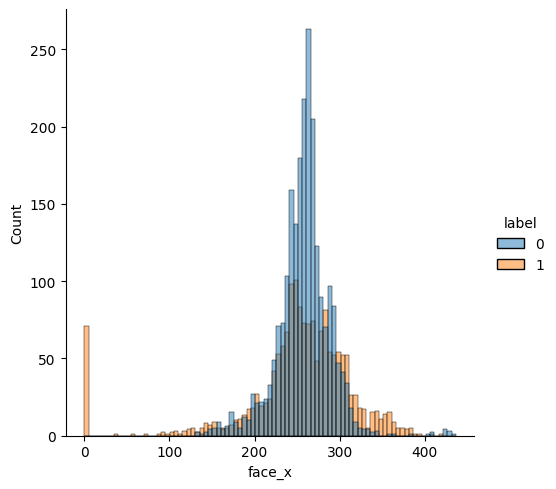

In [90]:
sns.displot(data=df, x='face_x', hue='label')

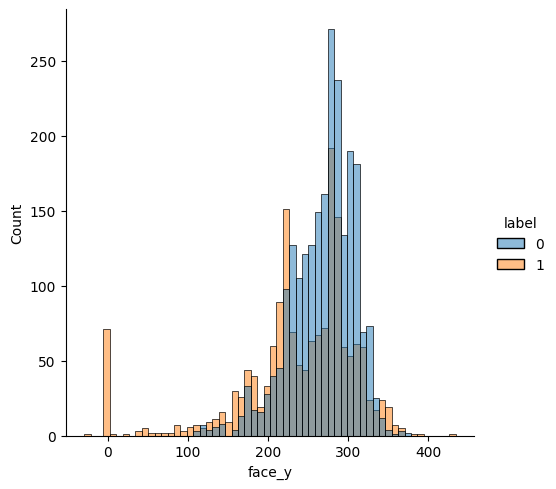

In [91]:
sns.displot(data=df, x='face_y', hue='label')

# Preprocessing

## Data Cleaning

Assumptions:
1. if there is no face (==0), person is distracted(==1)
2. if no_of_hands == 2, phone should be present == 1

In [5]:
df[(df['no_of_face']==2) & (df['label']==1)].shape[0]

28

In [6]:
pd.crosstab(df['phone'], df['no_of_hand'])

no_of_hand,0,1,2
phone,,,
0,1810,644,940
1,452,119,35


In [7]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

le = LabelEncoder()
df['pose'] = le.fit_transform(df['pose'])

<Axes: >

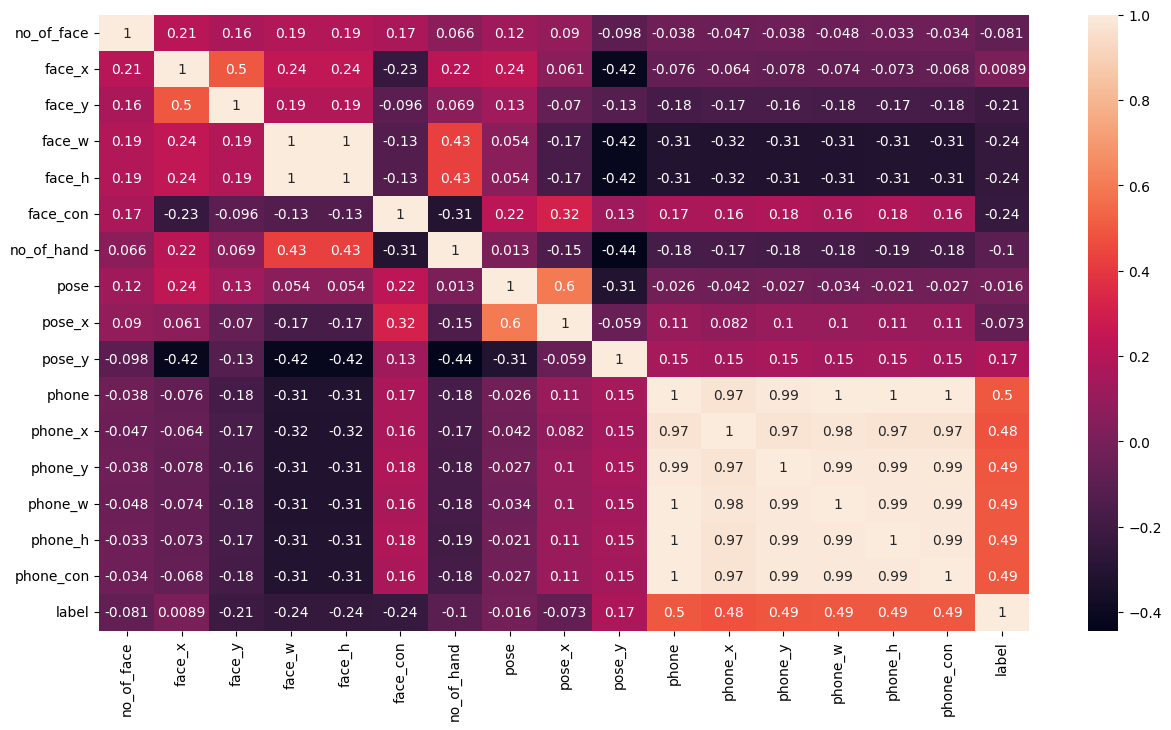

In [8]:
plt.figure(figsize=(15,8))

sns.heatmap(df.corr(method='spearman'), annot=True)

<Axes: >

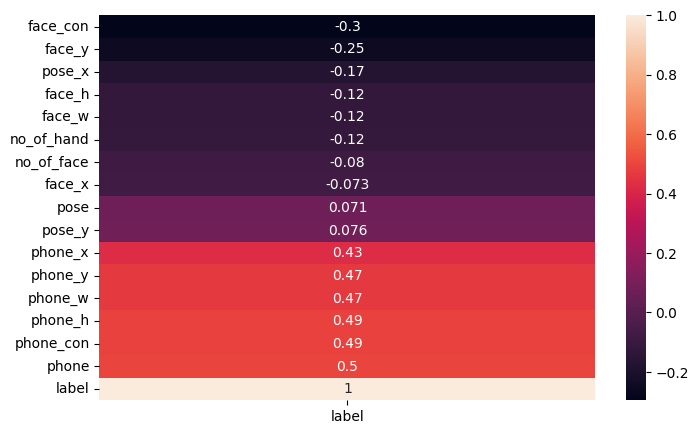

In [96]:
plt.figure(figsize=(8,5))
sns.heatmap(df.corr()[["label"]].sort_values(by='label',ascending=True),annot=True)

# Model Building

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline


# models
# from xgboost  import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [98]:
# X = df.drop('label', axis=1)
X = df[['no_of_face','face_con', 'pose', 'no_of_hand', 'phone', 'pose_x']]
y = df['label']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

X_train.shape, y_test.shape

((3000, 6), (1000,))

## Logistic Regression

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       544
           1       0.95      0.71      0.82       456

    accuracy                           0.85      1000
   macro avg       0.88      0.84      0.85      1000
weighted avg       0.87      0.85      0.85      1000



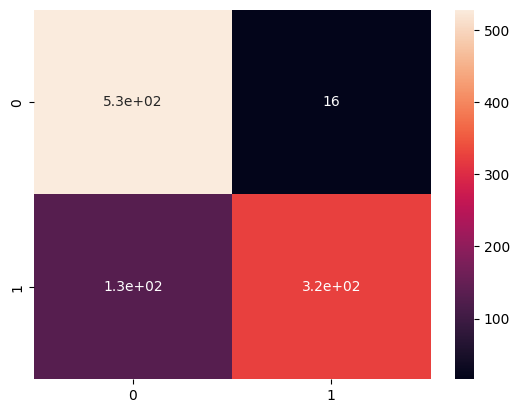

In [100]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('lr', LogisticRegression())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

## Random Forest

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       544
           1       0.98      0.94      0.96       456

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



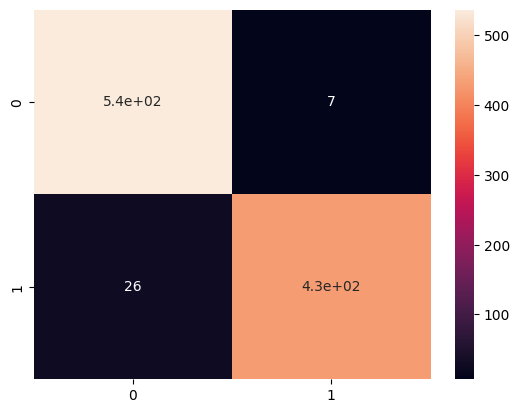

In [101]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('rfc', RandomForestClassifier())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

## Gradient Boosting

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       544
           1       0.98      0.94      0.96       456

    accuracy                           0.96      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



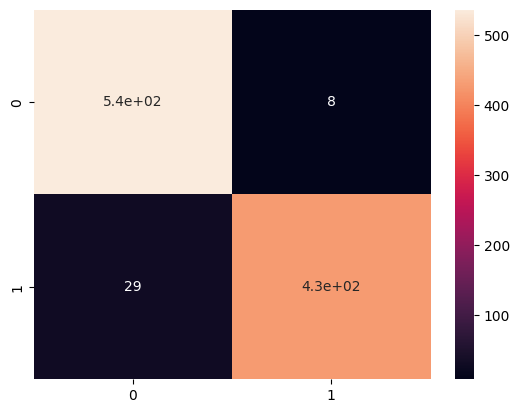

In [102]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('gb', GradientBoostingClassifier())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

## XGB

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       544
           1       0.98      0.94      0.96       456

    accuracy                           0.97      1000
   macro avg       0.97      0.96      0.97      1000
weighted avg       0.97      0.97      0.97      1000



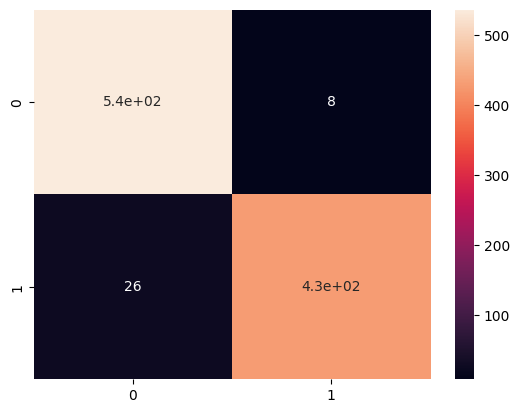

In [103]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('xgb', XGBClassifier())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

## SVC

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       544
           1       1.00      0.89      0.94       456

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



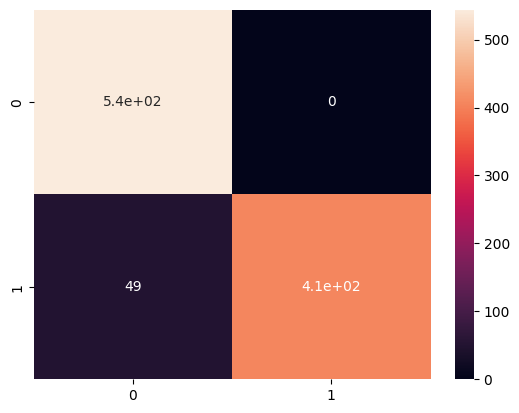

In [104]:
pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('svc', SVC())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.show()

# XAI

In [105]:
import shap, xgboost
# shap on voting classifier
xgb = XGBClassifier().fit(X_train, y_train)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

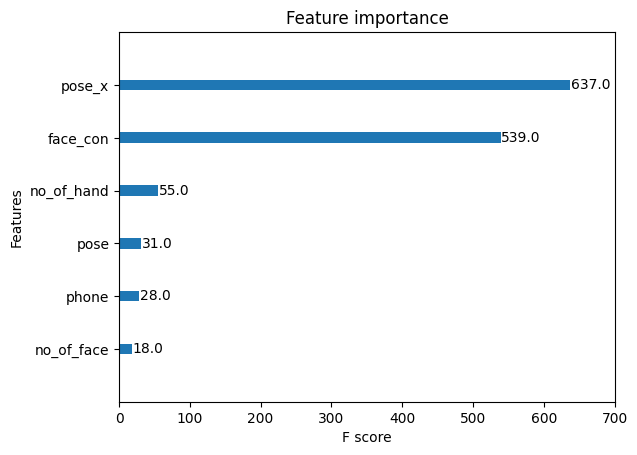

In [106]:
xgboost.plot_importance(xgb)
plt.grid()

Instance number: 294
Actual class: 0
Predicted class: 0
Class 0 Possiblity: 0.91
Class 1 Possiblity: 0.09


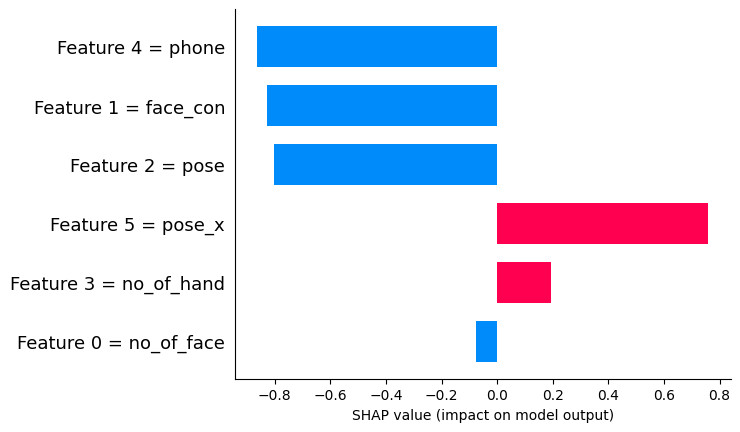

In [110]:
shap.initjs()
instance = np.random.randint(0,1000) 
print(f"Instance number: {instance}")

preds = xgb.predict(X_test)
probablity = xgb.predict_proba(X_test)

print(f"Actual class: {y_test.iloc[instance]}")
print(f"Predicted class: {preds[instance]}")
print(f"Class 0 Possiblity: {probablity[instance][0]:.2f}")
print(f"Class 1 Possiblity: {probablity[instance][1]:.2f}")


# print(X_test.iloc[instance])
# print(shap_values[instance])

shap.bar_plot(shap_values[instance], X_test, max_display=10)
shap.force_plot(explainer.expected_value, shap_values[instance], X_test.iloc[instance, :])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


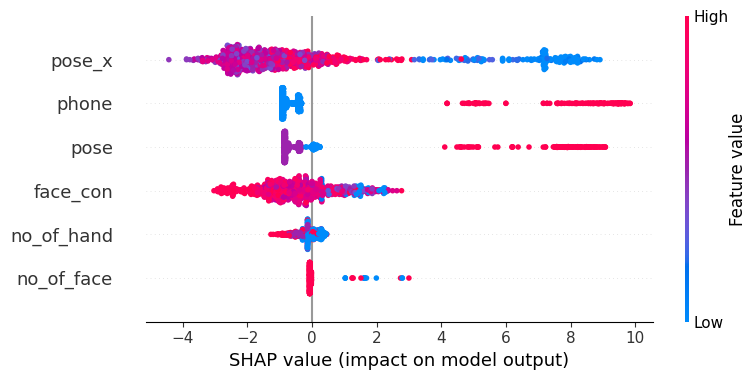

In [111]:
shap.summary_plot(shap_values, X_test)

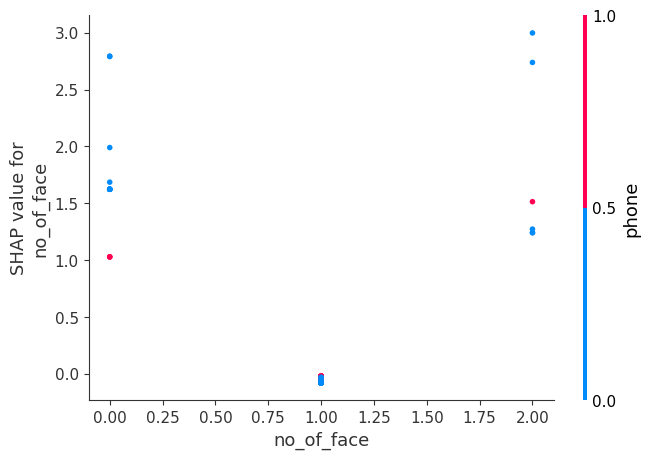

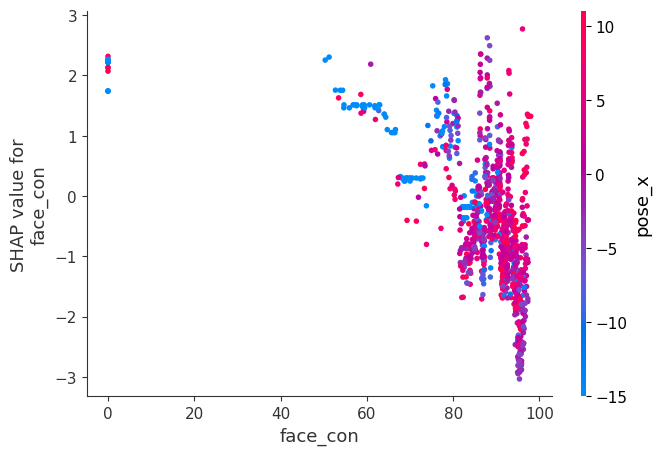

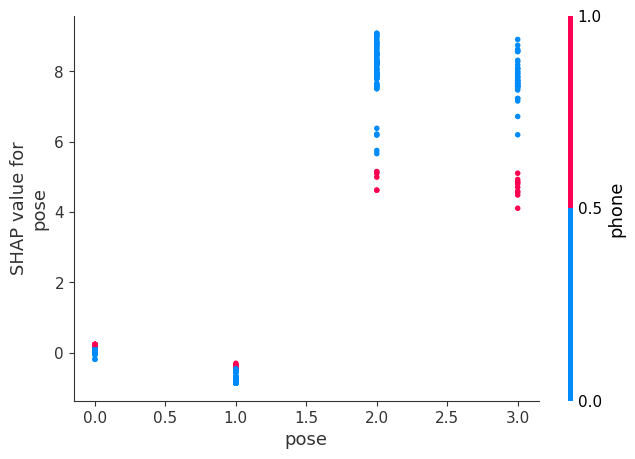

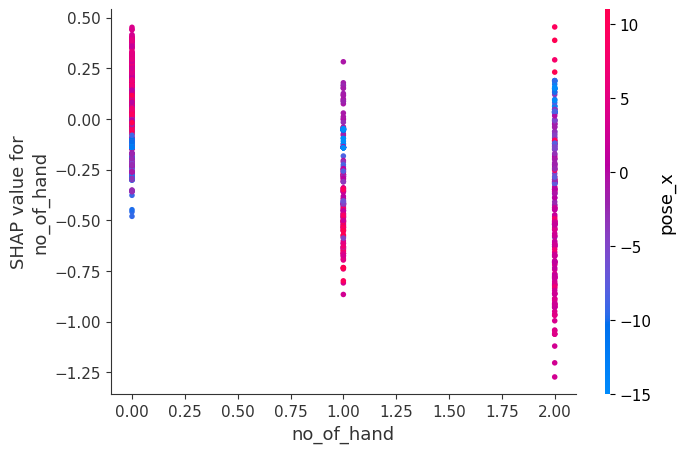

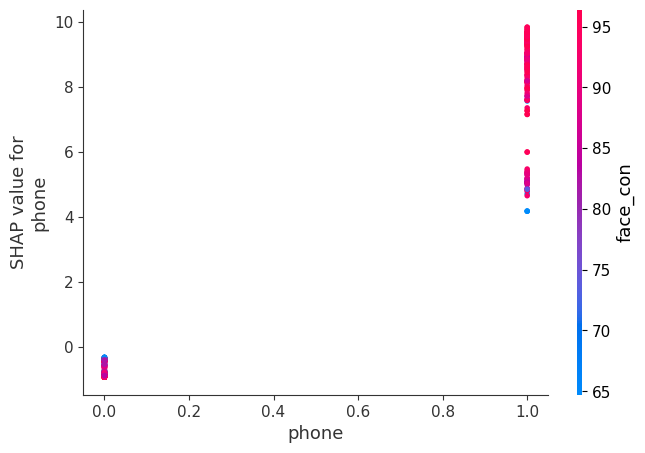

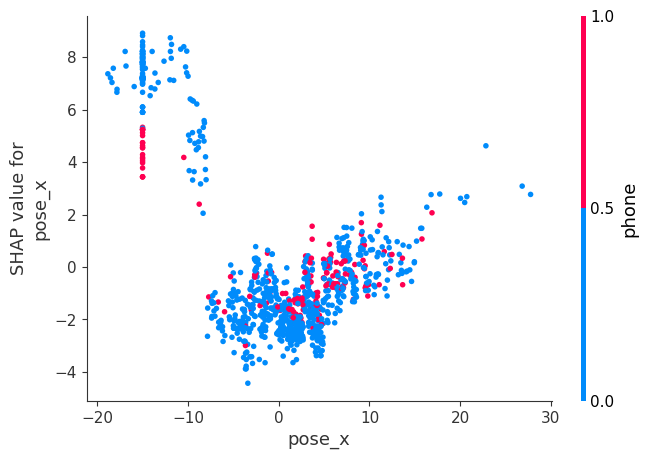

In [112]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_test, display_features=X_test)